In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x * 2. - 1.)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class UNet(nn.Module): 
    def __init__(self, in_channels=3, base_channels=64, num_classes=10, cond_dropout=0.1): 
        super().__init__()
        self.cond_dropout = cond_dropout
        self.label_emb = nn.Embedding(num_classes, 1)

        # Downsampling path 
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 2, base_channels, 3, padding=1), nn.ReLU(), 
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck 
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1), nn.ReLU(), 
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1), nn.ReLU()
        )

        # Upsampling path 
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding=1), nn.ReLU(), 
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels, 3, padding=1), nn.ReLU(), 
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(base_channels, in_channels, 1)
        
    def forward(self, x, t, y=None): 
        # Time embedding
        t = t[:, None, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        
        # Classifier-free dropout
        if y is not None and torch.rand(1).item() < self.cond_dropout:
            y = None
        y_emb = self.label_emb(y) if y is not None else torch.zeros(x.size(0), 1, device=x.device)
        y_emb = y_emb[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])

        x = torch.cat([x, t, y_emb], dim=1)

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        mid = self.middle(self.pool2(e2))

        d1 = self.up1(mid)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))

        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))

        return self.final(d2)

In [4]:
def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

def q_sample(x_start, t, noise):
    return sqrt_alphas_cumprod[t][:, None, None, None] * x_start +            sqrt_one_minus_alphas_cumprod[t][:, None, None, None] * noise


100%|██████████| 391/391 [00:08<00:00, 44.79it/s]


Epoch 1 - avg loss: 1.0150


100%|██████████| 391/391 [00:07<00:00, 50.38it/s]


Epoch 2 - avg loss: 0.6475


100%|██████████| 391/391 [00:08<00:00, 45.59it/s]


Epoch 3 - avg loss: 0.1586


100%|██████████| 391/391 [00:08<00:00, 45.34it/s]


Epoch 4 - avg loss: 0.0914


100%|██████████| 391/391 [00:08<00:00, 45.96it/s]


Epoch 5 - avg loss: 0.0769


100%|██████████| 391/391 [00:07<00:00, 50.56it/s]


Epoch 6 - avg loss: 0.0680


100%|██████████| 391/391 [00:08<00:00, 46.38it/s]


Epoch 7 - avg loss: 0.0617


100%|██████████| 391/391 [00:08<00:00, 45.41it/s]


Epoch 8 - avg loss: 0.0570


100%|██████████| 391/391 [00:07<00:00, 50.18it/s]


Epoch 9 - avg loss: 0.0548


100%|██████████| 391/391 [00:08<00:00, 47.95it/s]


Epoch 10 - avg loss: 0.0529


100%|██████████| 391/391 [00:08<00:00, 45.36it/s]


Epoch 11 - avg loss: 0.0501


100%|██████████| 391/391 [00:08<00:00, 45.91it/s]


Epoch 12 - avg loss: 0.0490


100%|██████████| 391/391 [00:07<00:00, 51.28it/s]


Epoch 13 - avg loss: 0.0470


100%|██████████| 391/391 [00:08<00:00, 45.28it/s]


Epoch 14 - avg loss: 0.0471


100%|██████████| 391/391 [00:07<00:00, 49.56it/s]


Epoch 15 - avg loss: 0.0458


100%|██████████| 391/391 [00:08<00:00, 47.59it/s]


Epoch 16 - avg loss: 0.0450


100%|██████████| 391/391 [00:08<00:00, 44.97it/s]


Epoch 17 - avg loss: 0.0447


100%|██████████| 391/391 [00:08<00:00, 46.09it/s]


Epoch 18 - avg loss: 0.0436


100%|██████████| 391/391 [00:08<00:00, 45.05it/s]


Epoch 19 - avg loss: 0.0436


100%|██████████| 391/391 [00:08<00:00, 45.59it/s]


Epoch 20 - avg loss: 0.0431


100%|██████████| 391/391 [00:08<00:00, 46.38it/s]


Epoch 21 - avg loss: 0.0422


100%|██████████| 391/391 [00:08<00:00, 45.72it/s]


Epoch 22 - avg loss: 0.0424


100%|██████████| 391/391 [00:08<00:00, 44.99it/s]


Epoch 23 - avg loss: 0.0419


100%|██████████| 391/391 [00:08<00:00, 45.70it/s]


Epoch 24 - avg loss: 0.0415


100%|██████████| 391/391 [00:08<00:00, 45.06it/s]


Epoch 25 - avg loss: 0.0413


100%|██████████| 391/391 [00:08<00:00, 47.90it/s]


Epoch 26 - avg loss: 0.0409


100%|██████████| 391/391 [00:08<00:00, 44.54it/s]


Epoch 27 - avg loss: 0.0406


100%|██████████| 391/391 [00:08<00:00, 46.01it/s]


Epoch 28 - avg loss: 0.0413


100%|██████████| 391/391 [00:08<00:00, 48.37it/s]


Epoch 29 - avg loss: 0.0404


100%|██████████| 391/391 [00:07<00:00, 50.84it/s]


Epoch 30 - avg loss: 0.0396


100%|██████████| 391/391 [00:08<00:00, 45.67it/s]


Epoch 31 - avg loss: 0.0397


100%|██████████| 391/391 [00:08<00:00, 46.09it/s]


Epoch 32 - avg loss: 0.0399


100%|██████████| 391/391 [00:07<00:00, 52.04it/s]


Epoch 33 - avg loss: 0.0391


100%|██████████| 391/391 [00:08<00:00, 45.94it/s]


Epoch 34 - avg loss: 0.0398


100%|██████████| 391/391 [00:08<00:00, 43.62it/s]


Epoch 35 - avg loss: 0.0395


100%|██████████| 391/391 [00:08<00:00, 46.72it/s]


Epoch 36 - avg loss: 0.0396


100%|██████████| 391/391 [00:08<00:00, 45.21it/s]


Epoch 37 - avg loss: 0.0385


100%|██████████| 391/391 [00:08<00:00, 45.19it/s]


Epoch 38 - avg loss: 0.0388


100%|██████████| 391/391 [00:08<00:00, 47.04it/s]


Epoch 39 - avg loss: 0.0386


100%|██████████| 391/391 [00:08<00:00, 47.59it/s]


Epoch 40 - avg loss: 0.0385


100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Epoch 41 - avg loss: 0.0380


100%|██████████| 391/391 [00:08<00:00, 45.35it/s]


Epoch 42 - avg loss: 0.0380


100%|██████████| 391/391 [00:08<00:00, 46.04it/s]


Epoch 43 - avg loss: 0.0381


100%|██████████| 391/391 [00:07<00:00, 50.70it/s]


Epoch 44 - avg loss: 0.0382


100%|██████████| 391/391 [00:08<00:00, 48.53it/s]


Epoch 45 - avg loss: 0.0380


100%|██████████| 391/391 [00:08<00:00, 46.87it/s]


Epoch 46 - avg loss: 0.0381


100%|██████████| 391/391 [00:08<00:00, 44.99it/s]


Epoch 47 - avg loss: 0.0382


100%|██████████| 391/391 [00:08<00:00, 46.89it/s]


Epoch 48 - avg loss: 0.0378


100%|██████████| 391/391 [00:08<00:00, 45.90it/s]


Epoch 49 - avg loss: 0.0375


100%|██████████| 391/391 [00:08<00:00, 44.97it/s]


Epoch 50 - avg loss: 0.0375


100%|██████████| 391/391 [00:08<00:00, 45.48it/s]


Epoch 51 - avg loss: 0.0375


100%|██████████| 391/391 [00:08<00:00, 46.43it/s]


Epoch 52 - avg loss: 0.0369


100%|██████████| 391/391 [00:08<00:00, 45.29it/s]


Epoch 53 - avg loss: 0.0368


100%|██████████| 391/391 [00:08<00:00, 44.85it/s]


Epoch 54 - avg loss: 0.0376


100%|██████████| 391/391 [00:08<00:00, 45.22it/s]


Epoch 55 - avg loss: 0.0377


100%|██████████| 391/391 [00:08<00:00, 45.93it/s]


Epoch 56 - avg loss: 0.0370


100%|██████████| 391/391 [00:07<00:00, 50.29it/s]


Epoch 57 - avg loss: 0.0367


100%|██████████| 391/391 [00:07<00:00, 50.87it/s]


Epoch 58 - avg loss: 0.0370


100%|██████████| 391/391 [00:08<00:00, 48.27it/s]


Epoch 59 - avg loss: 0.0366


100%|██████████| 391/391 [00:08<00:00, 44.91it/s]


Epoch 60 - avg loss: 0.0366


100%|██████████| 391/391 [00:08<00:00, 45.03it/s]


Epoch 61 - avg loss: 0.0365


100%|██████████| 391/391 [00:08<00:00, 44.35it/s]


Epoch 62 - avg loss: 0.0363


100%|██████████| 391/391 [00:08<00:00, 45.40it/s]


Epoch 63 - avg loss: 0.0366


100%|██████████| 391/391 [00:08<00:00, 45.21it/s]


Epoch 64 - avg loss: 0.0364


100%|██████████| 391/391 [00:07<00:00, 50.92it/s]


Epoch 65 - avg loss: 0.0362


100%|██████████| 391/391 [00:08<00:00, 45.40it/s]


Epoch 66 - avg loss: 0.0364


100%|██████████| 391/391 [00:08<00:00, 45.51it/s]


Epoch 67 - avg loss: 0.0364


100%|██████████| 391/391 [00:07<00:00, 48.97it/s]


Epoch 68 - avg loss: 0.0360


100%|██████████| 391/391 [00:07<00:00, 49.72it/s]


Epoch 69 - avg loss: 0.0361


100%|██████████| 391/391 [00:08<00:00, 44.35it/s]


Epoch 70 - avg loss: 0.0351


100%|██████████| 391/391 [00:08<00:00, 46.26it/s]


Epoch 71 - avg loss: 0.0362


100%|██████████| 391/391 [00:07<00:00, 51.44it/s]


Epoch 72 - avg loss: 0.0362


100%|██████████| 391/391 [00:08<00:00, 48.72it/s]


Epoch 73 - avg loss: 0.0365


100%|██████████| 391/391 [00:08<00:00, 46.79it/s]


Epoch 74 - avg loss: 0.0355


100%|██████████| 391/391 [00:08<00:00, 45.80it/s]


Epoch 75 - avg loss: 0.0355


100%|██████████| 391/391 [00:08<00:00, 45.35it/s]


Epoch 76 - avg loss: 0.0355


100%|██████████| 391/391 [00:08<00:00, 45.77it/s]


Epoch 77 - avg loss: 0.0357


100%|██████████| 391/391 [00:08<00:00, 46.93it/s]


Epoch 78 - avg loss: 0.0354


100%|██████████| 391/391 [00:08<00:00, 44.84it/s]


Epoch 79 - avg loss: 0.0353


100%|██████████| 391/391 [00:08<00:00, 45.56it/s]


Epoch 80 - avg loss: 0.0352


100%|██████████| 391/391 [00:08<00:00, 44.97it/s]


Epoch 81 - avg loss: 0.0356


100%|██████████| 391/391 [00:08<00:00, 44.80it/s]


Epoch 82 - avg loss: 0.0356


100%|██████████| 391/391 [00:08<00:00, 46.71it/s]


Epoch 83 - avg loss: 0.0357


100%|██████████| 391/391 [00:07<00:00, 51.30it/s]


Epoch 84 - avg loss: 0.0356


100%|██████████| 391/391 [00:08<00:00, 48.68it/s]


Epoch 85 - avg loss: 0.0359


100%|██████████| 391/391 [00:08<00:00, 45.15it/s]


Epoch 86 - avg loss: 0.0356


100%|██████████| 391/391 [00:07<00:00, 48.92it/s]


Epoch 87 - avg loss: 0.0350


100%|██████████| 391/391 [00:08<00:00, 45.02it/s]


Epoch 88 - avg loss: 0.0353


100%|██████████| 391/391 [00:08<00:00, 46.51it/s]


Epoch 89 - avg loss: 0.0351


100%|██████████| 391/391 [00:07<00:00, 50.50it/s]


Epoch 90 - avg loss: 0.0351


100%|██████████| 391/391 [00:08<00:00, 45.00it/s]


Epoch 91 - avg loss: 0.0349


100%|██████████| 391/391 [00:08<00:00, 44.92it/s]


Epoch 92 - avg loss: 0.0350


100%|██████████| 391/391 [00:08<00:00, 48.02it/s]


Epoch 93 - avg loss: 0.0349


100%|██████████| 391/391 [00:08<00:00, 45.51it/s]


Epoch 94 - avg loss: 0.0354


100%|██████████| 391/391 [00:08<00:00, 45.60it/s]


Epoch 95 - avg loss: 0.0352


100%|██████████| 391/391 [00:07<00:00, 49.56it/s]


Epoch 96 - avg loss: 0.0355


100%|██████████| 391/391 [00:07<00:00, 49.02it/s]


Epoch 97 - avg loss: 0.0344


100%|██████████| 391/391 [00:08<00:00, 45.57it/s]


Epoch 98 - avg loss: 0.0350


100%|██████████| 391/391 [00:08<00:00, 47.30it/s]


Epoch 99 - avg loss: 0.0347


100%|██████████| 391/391 [00:07<00:00, 51.11it/s]


Epoch 100 - avg loss: 0.0351


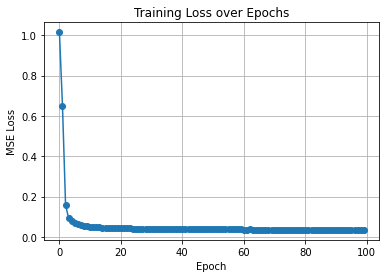

In [5]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
num_epochs = 100

train_losses = []

for epoch in range(num_epochs):  # adjust as needed
    model.train()
    epoch_loss = 0
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()
        noise = torch.randn_like(x)
        x_t = q_sample(x, t, noise)
        pred = model(x_t, t, y)
        loss = F.mse_loss(pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x.size(0)
    
    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - avg loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()

In [6]:
@torch.no_grad()
def p_sample(model, x, t, y, guidance_scale=5.0):
    eps_cond = model(x, t, y)
    eps_uncond = model(x, t, None)
    eps = (1 + guidance_scale) * eps_cond - guidance_scale * eps_uncond
    alpha_t = alphas[t][:, None, None, None]
    alpha_bar_t = alphas_cumprod[t][:, None, None, None]
    beta_t = betas[t][:, None, None, None]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
    sqrt_recip_alpha_bar_t = (1. / sqrt_alphas_cumprod[t])[:, None, None, None]

    x0_pred = (x - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alphas_cumprod[t][:, None, None, None]
    mean = (1 / torch.sqrt(alpha_t)) * (x - beta_t * eps / sqrt_one_minus_alpha_bar_t)
    if t[0] == 0:
        return x0_pred
    noise = torch.randn_like(x)
    return mean + torch.sqrt(beta_t) * noise


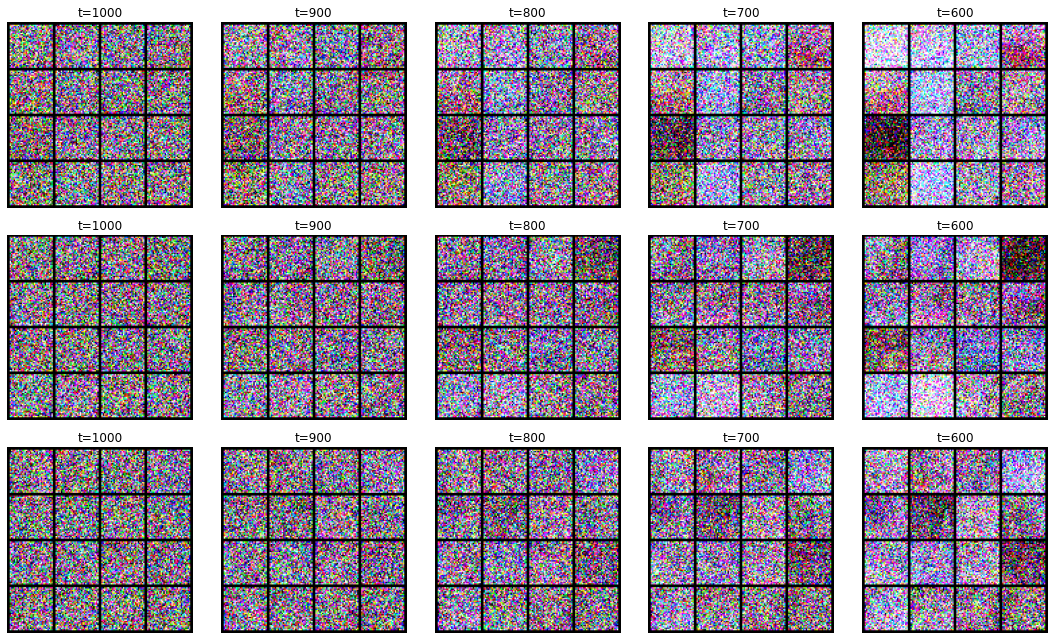

In [7]:
@torch.no_grad()
def sample_ddpm(model, label, guidance_scale=5.0):
    model.eval()
    x = torch.randn((16, 3, 32, 32)).to(device)
    imgs = []
    for t_val in reversed(range(T)):
        t = torch.tensor([t_val] * x.size(0)).to(device)
        x = p_sample(model, x, t, torch.tensor([label] * x.size(0)).to(device), guidance_scale)
        if t_val % 100 == 0:
            imgs.append(x.clamp(-1, 1).cpu())
    return imgs

# Generate and visualize with different guidance scales
scales = [0.0, 2.5, 5.0]
fig, axs = plt.subplots(len(scales), 5, figsize=(15, 9))

for i, scale in enumerate(scales):
    imgs = sample_ddpm(model, label=3, guidance_scale=scale)
    for j in range(5):
        grid = make_grid(imgs[j], nrow=4, normalize=True, value_range=(-1, 1))
        axs[i, j].imshow(grid.permute(1, 2, 0))
        axs[i, j].set_title(f"t={T - j * 100}")
        axs[i, j].axis('off')
    axs[i, 0].set_ylabel(f"Scale={scale}", fontsize=14)

plt.tight_layout()
plt.show()

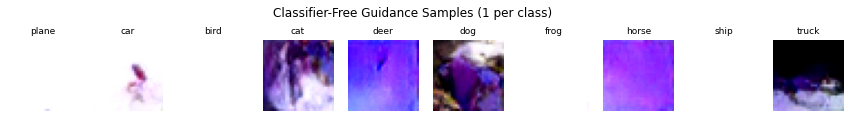

In [8]:
@torch.no_grad()
def sample_multiple_classes(model, labels, guidance_scale=5.0):
    model.eval()
    n = len(labels)
    x = torch.randn((n, 3, 32, 32)).to(device)
    for t_val in reversed(range(T)):
        t = torch.tensor([t_val] * n).to(device)
        x = p_sample(model, x, t, torch.tensor(labels).to(device), guidance_scale)
    return x.clamp(-1, 1).cpu()

# Visualize samples for all 10 CIFAR-10 classes
label_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = list(range(10))
samples = sample_multiple_classes(model, labels, guidance_scale=5.0)

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i, img in enumerate(samples):
    axs[i].imshow((img.permute(1, 2, 0) + 1) / 2)
    axs[i].set_title(label_names[i], fontsize=9)
    axs[i].axis('off')
plt.suptitle("Classifier-Free Guidance Samples (1 per class)")
plt.show()


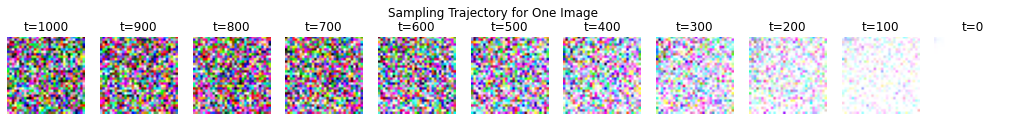

In [9]:
@torch.no_grad()
def visualize_trajectory(model, label=3, guidance_scale=5.0):
    x = torch.randn((1, 3, 32, 32)).to(device)
    trajectory = []

    for t_val in reversed(range(T)):
        t = torch.tensor([t_val]).to(device)
        x = p_sample(model, x, t, torch.tensor([label]).to(device), guidance_scale)
        if t_val % 100 == 0 or t_val in [0, T-1]:
            trajectory.append(x.squeeze().clamp(-1, 1).cpu())

    # Plot
    fig, axs = plt.subplots(1, len(trajectory), figsize=(18, 2))
    for i, img in enumerate(trajectory):
        axs[i].imshow((img.permute(1, 2, 0) + 1) / 2)
        axs[i].set_title(f"t={T - i*100}")
        axs[i].axis("off")
    plt.suptitle("Sampling Trajectory for One Image")
    plt.show()

# Visualize
visualize_trajectory(model, label=3, guidance_scale=5.0)
